# Training Vision Transformer (ViT) on *Dogs vs Cats Data* 
ViT is a transformer encoder model (BERT-like) pretrained on a large collection of images in a supervised fashion, namely ImageNet-21k, at a resolution of 224x224 pixels. Next, the model was fine-tuned on ImageNet (also referred to as ILSVRC2012), a dataset comprising 1 million images and 1,000 classes, also at resolution 224x224. It was introduced in the paper An **Image is Worth 16x16 Words: Transformers for Image Recognition at Scale** by Dosovitskiy et al.



    
* Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
    
* Vit Implementation is from **huggingface.co** available in https://huggingface.co/transformers/model_doc/vit.html<p><br>

<div>
<img src="./Sources/1.jpg" width="100" height="100"/>
</div>

<p><br>

In [2]:
!nvidia-smi

Wed Aug 11 09:59:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Install library

In [4]:
!pip install -q git+https://github.com/huggingface/transformers

## Import Libraries

In [5]:
from __future__ import print_function

import glob
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

# Use GPU if available  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

# Setting Parameters

In [6]:
# Training settings
batch_size = 64
EPOCHS = 20
lr = 0.01

## Read and Load Data

In [7]:
os.makedirs('data', exist_ok=True)

In [8]:
train_dir = 'data/train'
test_dir = 'data/test'

In [9]:
with zipfile.ZipFile('../input/dogs-vs-cats-redux-kernels-edition/train.zip') as train_zip:
    train_zip.extractall('data')
    
with zipfile.ZipFile('../input/dogs-vs-cats-redux-kernels-edition/test.zip') as test_zip:
    test_zip.extractall('data')

In [38]:
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

## Reduce size of data to develop

In [39]:
import random
train_list=random.sample(train_list, 2000)
test_list=random.sample(test_list, 1000)

In [40]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 2000
Test Data: 1000


In [41]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]
len(labels)

2000

## Random Plots

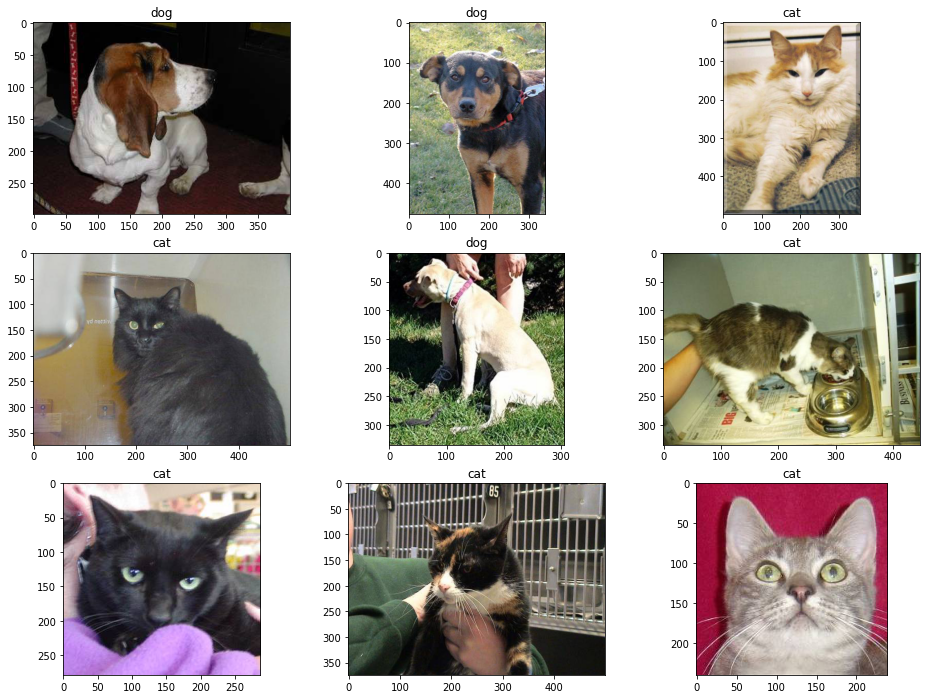

In [15]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

## Split tarin data 

In [42]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels)

In [43]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 1600
Validation Data: 400
Test Data: 1000


## Image Augumentation

In [44]:
im_size=224
train_transforms = transforms.Compose(
    [
        transforms.Resize((im_size, im_size)),
        transforms.RandomResizedCrop(im_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((im_size, im_size)),
        transforms.RandomResizedCrop(im_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((im_size, im_size)),
        transforms.RandomResizedCrop(im_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


## Datasets and DataLoaders

In [45]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
        self.classes = ['gog','cat']
        
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0

        return img_transformed, label


In [49]:
train_ds= CatsDogsDataset(train_list, transform=train_transforms)
valid_ds = CatsDogsDataset(valid_list, transform=test_transforms)
test_ds = CatsDogsDataset(test_list, transform=test_transforms)

In [51]:
train_loader = DataLoader(dataset = train_ds, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_ds, batch_size=batch_size, shuffle=True)

In [52]:
print(len(train_ds), len(train_loader))

1600 25


In [53]:
print(len(valid_ds), len(valid_loader))

400 7


In [54]:
batch=next(iter(train_loader))
batch[0].shape,batch[1].shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

# Creating ViTModel

In [55]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=3):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)
        return logits
        


In [56]:
from transformers import ViTFeatureExtractor
import torch.nn as nn
import torch

# Define Model
model = ViTForImageClassification(len(train_ds.classes))    

# Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# Adam Optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.9, weight_decay=1e-4)

# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()

model = model.to(device)

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [57]:
for epoch in range(EPOCHS):
    epoch_loss = 0
    epoch_accuracy = 0

    for batch, (inputs, targets) in enumerate(train_loader):
          inputs, targets = inputs.to(device), targets.to(device)

          outputs = model(inputs,targets)
        
          loss = loss_func(outputs, targets)   
          optimizer.zero_grad()           
          loss.backward()                 
          optimizer.step()
      
          acc = (outputs.argmax(dim=1) == targets).float().mean()
          epoch_accuracy += acc / len(train_loader)
          epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for batch, (inputs, targets) in enumerate(valid_loader):
              inputs, targets = inputs.to(device), targets.to(device)


              val_output = model(inputs,targets)
              val_loss = loss_func(val_output, targets)   
          
              acc = (val_output.argmax(dim=1) == targets).float().mean()
              epoch_val_accuracy += acc / len(valid_loader)
              epoch_val_loss += val_loss / len(valid_loader)
                       
    print(  f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n")


Epoch : 1 - loss : 0.3560 - acc: 0.8769 - val_loss : 0.0694 - val_acc: 0.9911

Epoch : 2 - loss : 0.0619 - acc: 0.9800 - val_loss : 0.0823 - val_acc: 0.9688

Epoch : 3 - loss : 0.0781 - acc: 0.9731 - val_loss : 0.0946 - val_acc: 0.9576

Epoch : 4 - loss : 0.0689 - acc: 0.9731 - val_loss : 0.0756 - val_acc: 0.9754

Epoch : 5 - loss : 0.0526 - acc: 0.9806 - val_loss : 0.0638 - val_acc: 0.9799

Epoch : 6 - loss : 0.0423 - acc: 0.9806 - val_loss : 0.0412 - val_acc: 0.9799

Epoch : 7 - loss : 0.0404 - acc: 0.9850 - val_loss : 0.0487 - val_acc: 0.9844

Epoch : 8 - loss : 0.0425 - acc: 0.9838 - val_loss : 0.0582 - val_acc: 0.9799

Epoch : 9 - loss : 0.0366 - acc: 0.9838 - val_loss : 0.0279 - val_acc: 0.9888

Epoch : 10 - loss : 0.0348 - acc: 0.9850 - val_loss : 0.0519 - val_acc: 0.9866

Epoch : 11 - loss : 0.0399 - acc: 0.9863 - val_loss : 0.0655 - val_acc: 0.9799

Epoch : 12 - loss : 0.0239 - acc: 0.9919 - val_loss : 0.0462 - val_acc: 0.9821

Epoch : 13 - loss : 0.0319 - acc: 0.9906 - val_lo

## Evaluate on a Test Image from validation set

Finally, let's evaluate the model on a test image:

torch.Size([1, 3, 224, 224])
1


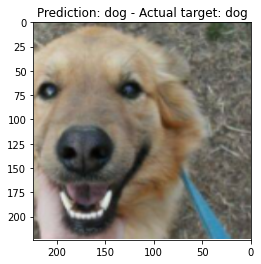

In [72]:

import matplotlib.pyplot as plt
import numpy as np

def lableing(s):
    if s==1:
        label = 'dog'
    else:
        label = 'cat'
    return label

EVAL_BATCH = 1
eval_loader  = DataLoader(valid_ds, batch_size=EVAL_BATCH, shuffle=True, num_workers=4) 
# Disable grad
with torch.no_grad():
    
  inputs, target = next(iter(eval_loader))
  # Reshape and get feature matrices as needed
  print(inputs.shape)
  inputs = inputs[0].permute(1, 2, 0)
  # Save original Input
  originalInput = inputs
  for index, array in enumerate(inputs):
    inputs[index] = np.squeeze(array)
  inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))

  # Send to appropriate computing device
  inputs = inputs.to(device)
  target = target.to(device)
 
  # Generate prediction
  prediction = model(inputs, target)
    
  # Predicted class value using argmax
  predicted_class = np.argmax(prediction.cpu())
  print(int(predicted_class))
  value_predicted = lableing(int(predicted_class))
  value_target = lableing(target)
        
  # Show result
  plt.imshow(originalInput)
  plt.xlim(224,0)
  plt.ylim(224,0)
  plt.title(f'Prediction: {value_predicted} - Actual target: {value_target}')
  plt.show()